#### **Use Grid Search to Find the most Informative Peaks**

Import Libraries

In [10]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from scipy.signal import peak_widths, peak_prominences
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate
from joblib import Parallel, delayed

Read the spectral data

In [11]:
#df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")
#df = pd.read_csv("../../data/current_clean_spectrum.csv", index_col=0)

In [12]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


#### **1 Sample Examples**

In [13]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber  Absorbance     SurID         Status
6206421  210526-3-04   293   400.22778   2418.5078  210526-3  Hyperglycemia
6206422  210526-3-04   294   400.91116   2425.2903  210526-3  Hyperglycemia
6206423  210526-3-04   295   401.59454   2440.9182  210526-3  Hyperglycemia
6206424  210526-3-04   296   402.27789   2452.6968  210526-3  Hyperglycemia
6206425  210526-3-04   297   402.96127   2452.4475  210526-3  Hyperglycemia
...              ...   ...         ...         ...       ...            ...
6208465  210526-3-04  2337  1797.03870   1994.6351  210526-3  Hyperglycemia
6208466  210526-3-04  2338  1797.72200   2007.0331  210526-3  Hyperglycemia
6208467  210526-3-04  2339  1798.40550   2007.3999  210526-3  Hyperglycemia
6208468  210526-3-04  2340  1799.08890   1982.2590  210526-3  Hyperglycemia
6208469  210526-3-04  2341  1799.77220   1974.7581  210526-3  Hyperglycemia

[2049 rows x 6 columns]


Find Peaks Within the spectrum.

In [14]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)
peaks, _ = find_peaks(x=sample['Absorbance'])

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

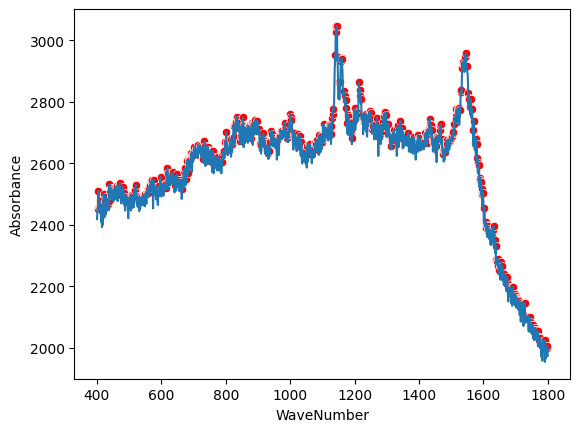

In [15]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[peaks], x="WaveNumber", y="Absorbance", color="red")

As you can see, it does not properly find the peaks, so we have to tune the peak finding parameters.

These parameters are based on Thomas Keogh's Search

In [16]:
tuned_peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

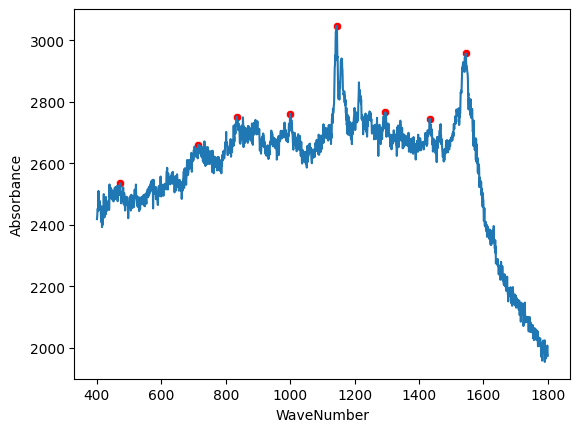

In [17]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[tuned_peaks], x="WaveNumber", y="Absorbance", color="red")

#### **Find the best Peak Finding Parameters**

Create a field for each wavelength.

Train an Extra Trees Classifier

In [18]:
def evaluate_extra_trees(df):
    # Splitting the dataframe into features (X) and target variable (y)
    X = df.drop(['Status'], axis=1)
    y = df['Status']
    
    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using StratifiedKFold for classification tasks
    #cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

#### **1. Using Peak Statistics**

In [19]:
backup = df

In [20]:
statuses = df[['SpecID', 'Status']].drop_duplicates()

This uses statistical properties of the peaks in each sample to be used as additional features.

In [21]:
peaks = []
widths = []
prominences = []

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    #peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], distance=None, prominence=None, width=None)

    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

/tmp/ipykernel_26216/2902688669.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_26216/2902688669.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [22]:
peaks_df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PeakWidths,PeakProminences
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,1.292782,9.1181
5,201210-1-00,298,403.64465,1763.2300,201210-1,Normal,0.969650,6.8080
8,201210-1-00,301,405.69476,1774.7166,201210-1,Normal,2.165110,29.4881
12,201210-1-00,305,408.42825,1780.3931,201210-1,Normal,2.082365,39.8827
17,201210-1-00,310,411.84509,1786.9565,201210-1,Normal,3.339786,54.8636
...,...,...,...,...,...,...,...,...
6228943,210526-3-49,2325,1788.83830,1031.7932,210526-3,Hyperglycemia,0.560744,2.0115
6228945,210526-3-49,2327,1790.20500,1044.6376,210526-3,Hyperglycemia,4.304446,38.4852
6228950,210526-3-49,2332,1793.62180,1013.8869,210526-3,Hyperglycemia,1.555230,1.6528
6228952,210526-3-49,2334,1794.98860,1015.2792,210526-3,Hyperglycemia,0.664909,4.8815


In [23]:
#sns.scatterplot(data=peaks_df, x="WaveNumber", y="Absorbance", hue='Status')

Standard Deviation of the Absorbances appears to have a positive affect on accuracy.

In [24]:
# Create a new DataFrame for the summary statistics
peak_stats = peaks_df.groupby('SpecID').agg({
    'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
    'PeakWidths': ['mean', 'std', 'max', 'min'],
    'PeakProminences': ['mean', 'std', 'max', 'min']
}).reset_index()

# Flatten the multi-level columns and customize the names
peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

In [25]:
# # Create a new DataFrame for the summary statistics
# peak_stats = peaks_df.groupby('SpecID').agg({
#     'PeakWidths': ['mean', 'std', 'max', 'min'],
#     'PeakProminences': ['mean', 'std', 'max', 'min']
# }).reset_index()

# # Flatten the multi-level columns and customize the names
# peak_stats.columns = ['SpecID',
#                       'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
#                       'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

Sometimes not every sample has a peak.

In [26]:
peak_stats.head()

,SpecID,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
0,201210-1-00,1576.267119,149.272956,606,1851.9185,1195.1451,2.237149,5.384110,107.305604,0.500097,20.760183,19.169266,193.5749,0.0025
1,201210-1-01,1750.923310,158.179648,603,2034.2784,1363.9469,2.208137,3.752500,54.616659,0.500664,21.659563,22.240880,219.8550,0.0154
2,201210-1-02,2151.185709,128.741830,581,3696.4109,1961.7175,2.065221,3.168006,36.809791,0.503868,28.335590,82.908710,1739.2382,0.1636
3,201210-1-03,2491.914904,253.553486,543,3452.3679,2010.0946,2.357339,5.347269,74.637545,0.502425,33.110171,92.269001,1332.8757,0.0330
4,201210-1-04,2205.550147,93.325951,588,2458.5142,1986.6266,2.535974,9.413553,217.370659,0.501460,25.944061,28.375253,446.3222,0.0173


In [27]:
peak_stats.shape

(3045, 14)

In [28]:
peak_stats = pd.merge(statuses, peak_stats, on='SpecID', how='left')
peak_stats = peak_stats.set_index('SpecID')
peak_stats = peak_stats.fillna(0)

In [29]:
peak_stats.shape

(3045, 14)

In [30]:
evaluate_extra_trees(peak_stats)

ExtraTreesClassifier Cross-Validation Accuracy: 0.7691 +/- 0.0220


##### **Find the best Peak Finding Parameters for the Stat Based Approach**

In [31]:
df = df.drop(columns=['Seq', 'SurID'])

In [32]:
df

,SpecID,WaveNumber,Absorbance,Status
0,201210-1-00,400.22778,1765.6628,Normal
1,201210-1-00,400.91116,1774.7809,Normal
2,201210-1-00,401.59454,1769.0302,Normal
3,201210-1-00,402.27789,1756.4220,Normal
4,201210-1-00,402.96127,1758.8690,Normal
...,...,...,...,...
6239200,210526-3-09,1797.03870,1617.3926,Hyperglycemia
6239201,210526-3-09,1797.72200,1633.0911,Hyperglycemia
6239202,210526-3-09,1798.40550,1633.3076,Hyperglycemia
6239203,210526-3-09,1799.08890,1641.8665,Hyperglycemia


In [33]:
# Define parameter ranges

# distances = [None, 5, 10, 20]
# prominences = [None, 0.01, 0.05, 0.1]
# widths = [None, 5, 10, 20]
# thresholds = [None, 0.01, 0.05, 0.1]

distances = [None, 5]
prominences = [None, 0.01]
widths = [None, 5]
thresholds = [None, 0.01]

# distances = [None]
# prominences = [None]
# widths = [None]
# thresholds = [None]

# distances = [None, 5, 10, 25, 50, 100, 150, 200, 250]
# prominences = [None, 5, 10, 25, 50, 100, 150, 200, 250]
# widths = [None, 1, 2, 5, 10, 20]
# thresholds = [None, 5, 10, 25, 50, 100, 150, 200, 250]

In [34]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Ignore UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [35]:
def preprocess_and_extract_peaks(df, distance, prominence, width, threshold):
    
    widths = []
    prominences = []
    peaks = []
    
    for _, group in df.groupby('SpecID'):

        peak_index, _ = find_peaks(x=group['Absorbance'], distance=distance, prominence=prominence, width=width, threshold=threshold)

        # Calculate the widths of each peak
        widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

        # Calculate prominence of each peak
        prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

        # Find the index of the peak within the full dataframe
        peaks += list(group.iloc[peak_index].index.values)

    peaks_df = df.loc[peaks].copy()
    peaks_df['PeakWidths'] = widths
    peaks_df['PeakProminences'] = prominences
    return peaks_df

In [36]:
def evaluate_model_with_cross_validation(df, distance, prominence, width, threshold):
    
    df_copy = df.copy()
    peaks_df = preprocess_and_extract_peaks(df_copy, distance, prominence, width, threshold)

    # Average peak count per spectrum
    avg_peak_count = len(peaks_df)/3045

    # Create a new DataFrame for the summary statistics
    peak_stats = peaks_df.groupby('SpecID').agg({
        'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
        'PeakWidths': ['mean', 'std', 'max', 'min'],
        'PeakProminences': ['mean', 'std', 'max', 'min']
    }).reset_index()

    # Flatten the multi-level columns and customise the names
    peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']
    
    # Add the statuses back to the dataframe
    peak_stats = pd.merge(statuses, peak_stats, on='SpecID', how='left').set_index('SpecID').fillna(0)

    X = peak_stats.drop(['Status'], axis=1)
    y = peak_stats['Status']
    
    et = ExtraTreesClassifier(random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    scores = cross_validate(et, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
    
    return {
        'Distance': distance,
        'Prominence': prominence,
        'Width': width,
        'Threshold': threshold,
        'Average Peak Count': avg_peak_count,
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision_macro']),
        'Recall': np.mean(scores['test_recall_macro']),
        'F1': np.mean(scores['test_f1_macro']),
        'Accuracy Std': np.std(scores['test_accuracy']),
        'Precision Std': np.std(scores['test_precision_macro']),
        'Recall Std': np.std(scores['test_recall_macro']),
        'F1 Std': np.std(scores['test_f1_macro'])
        }

# Parallel execution
#results = Parallel(n_jobs=-1)(delayed(evaluate_model_with_cross_validation)(df, d, p, w, t) for d in distances for p in prominences for w in widths for t in thresholds)

results = []
for d in distances:
    for p in prominences:
        for w in widths:
            for t in thresholds:
                results.append(evaluate_model_with_cross_validation(df, d, p, w, t))

In [37]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Identify the best parameters based on the selected criteria
best_row = results_df.loc[results_df['Accuracy'].idxmax()]

print(f"Best Parameters: Distance={best_row['Distance']}, Prominence={best_row['Prominence']}, Width={best_row['Width']}, Thresholde={best_row['Threshold']} and Avg_Peak_Count={best_row['Average Peak Count']:.2f} with Accuracy: {best_row['Accuracy']:.4f}")

# Save the results to csv
results_df.sort_values('Accuracy', ascending=False).to_csv("Peak_Stat_Parameters.csv", index=False)

Best Parameters: Distance=5.0, Prominence=nan, Width=nan, Thresholde=0.01 and Avg_Peak_Count=273.23 with Accuracy: 0.7714


#### **2. Creating a uniform Peak Featureset**

This aims to create a featureset using peaks within wavenumber intervals.

Assign Peaks to bins of a fixed wavelength interval.

In [38]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

In [39]:
# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))

/tmp/ipykernel_26216/3718610318.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))


In [40]:
peaks_df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PeakWidths,PeakProminences,Bin
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,1.292782,9.1181,400-425
5,201210-1-00,298,403.64465,1763.2300,201210-1,Normal,0.969650,6.8080,400-425
8,201210-1-00,301,405.69476,1774.7166,201210-1,Normal,2.165110,29.4881,400-425
12,201210-1-00,305,408.42825,1780.3931,201210-1,Normal,2.082365,39.8827,400-425
17,201210-1-00,310,411.84509,1786.9565,201210-1,Normal,3.339786,54.8636,400-425


Set the bins as columns with the peak absrobances, widths and prominences as the values.
If no peaks appear in a bin the value is set to 0.
If multiple peaks appear their properties are aggregated.

In [41]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='mean')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = peaks_df[['SpecID', 'Status']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with 0
peak_bins.fillna(0, inplace=True)

In [42]:
peak_bins.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,PeakWidths_775-800,PeakWidths_800-825,PeakWidths_825-850,PeakWidths_850-875,PeakWidths_875-900,PeakWidths_900-925,PeakWidths_925-950,PeakWidths_950-975,PeakWidths_975-1000,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1676.614367,1648.945490,1641.533636,1609.467410,1584.282764,1583.702731,1566.829791,1540.627507,1532.548378,1554.378630,...,2.017591,1.649347,1.561565,1.832265,1.743153,10.983106,1.935292,1.587852,3.811261,Normal
201210-1-01,1850.223770,1807.834620,1796.397192,1781.903791,1742.360008,1754.410742,1740.136767,1717.390933,1690.534025,1703.333683,...,2.281389,2.218869,2.115753,2.862587,7.475917,1.535772,2.099247,1.604601,3.514267,Normal
201210-1-02,2230.114767,2269.415775,2185.438750,2147.305300,2138.580693,2181.926322,2149.798467,2128.800960,2134.047617,2158.381940,...,1.593174,1.720252,2.085322,2.058844,1.223848,9.047239,1.059486,2.146533,1.394968,Normal
201210-1-03,2794.472567,2686.154533,2668.953982,2627.199482,2632.071125,2811.216910,3085.499789,2823.964043,2561.175055,2575.402350,...,2.238786,1.746830,2.177291,1.244111,1.091365,13.186603,1.095389,1.347167,5.941780,Normal
201210-1-04,2191.990120,2172.530025,2178.623000,2166.319336,2172.167471,2215.143790,2231.904800,2247.914764,2228.238436,2232.069809,...,2.313365,2.537687,3.948108,2.114583,2.084560,2.353330,2.308692,2.034623,1.408506,Normal


In [43]:
evaluate_extra_trees(peak_bins)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8200 +/- 0.0234


##### **Find the best Peak Finding Parameters for the Bin Based Approach**

In [48]:
def evaluate_model_with_cross_validation(df, distance, prominence, width, threshold):
    
    df_copy = df.copy()
    peaks_df = preprocess_and_extract_peaks(df_copy, distance, prominence, width, threshold)

    # Average peak count per spectrum
    avg_peak_count = len(peaks_df)/3045

    # Set the bin size
    bin_size = 25

    # Add a "Bin" column to the DataFrame
    peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))
    peaks_df.head()
    
    # Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
    peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='mean')
    peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
    peak_bins.reset_index(inplace=True)

    # Merge with 'Status' information
    peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

    # Set 'SpecID' as the index
    peak_bins.set_index('SpecID', inplace=True)

    # Fill NaN values with 0
    peak_bins.fillna(0, inplace=True)
    
    X = peak_bins.drop(['Status'], axis=1)
    y = peak_bins['Status']
    
    et = ExtraTreesClassifier(random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    scores = cross_validate(et, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
    
    return {
        'Distance': distance,
        'Prominence': prominence,
        'Width': width,
        'Threshold': threshold,
        'Average Peak Count': avg_peak_count,
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision_macro']),
        'Recall': np.mean(scores['test_recall_macro']),
        'F1': np.mean(scores['test_f1_macro']),
        'Accuracy Std': np.std(scores['test_accuracy']),
        'Precision Std': np.std(scores['test_precision_macro']),
        'Recall Std': np.std(scores['test_recall_macro']),
        'F1 Std': np.std(scores['test_f1_macro'])
        }

# Parallel execution
#results = Parallel(n_jobs=-1)(delayed(evaluate_model_with_cross_validation)(df, d, p, w, t) for d in distances for p in prominences for w in widths for t in thresholds)

results = []
for d in distances:
    for p in prominences:
        for w in widths:
            for t in thresholds:
                results.append(evaluate_model_with_cross_validation(df, d, p, w, t))

In [49]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Identify the best parameters based on the selected criteria
best_row = results_df.loc[results_df['Accuracy'].idxmax()]

print(f"Best Parameters: Distance={best_row['Distance']}, Prominence={best_row['Prominence']}, Width={best_row['Width']}, Thresholde={best_row['Threshold']} and Avg_Peak_Count={best_row['Average Peak Count']:.2f} with Accuracy: {best_row['Accuracy']:.4f}")

# Save the results to csv
results_df.sort_values('Accuracy', ascending=False).to_csv("Peak_Bin_Parameters.csv", index=False)

Best Parameters: Distance=5.0, Prominence=nan, Width=nan, Thresholde=nan and Avg_Peak_Count=273.36 with Accuracy: 0.8325
